In [1]:
from pathlib import Path
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [90]:
import warnings
warnings.filterwarnings(action='ignore',category=UserWarning, message="Tight layout not applied.")

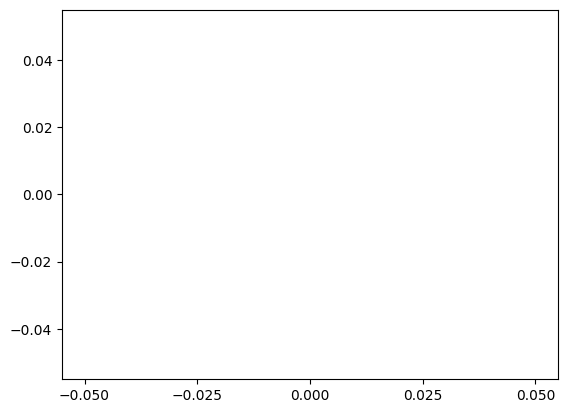

In [2]:
# Code that should make matplotlib use ACM font (libertine)
import matplotlib
plt.plot()
import shutil
latex_exists = shutil.which("latex") is not None
rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": latex_exists,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [3]:
dataset_path = None # read from file

In [4]:
def plot_external_legend(original_ax, identifier, figsize=(9, 0.5), fontsize=16):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig, legend_ax = plt.subplots(1, 1,figsize=figsize, sharey=True)
        #fig.set_facecolor("black")
        #fig.pad_inches(0)
        fig.set_tight_layout(True)
        #legend_ax.set_facecolor("black")
        #legend_ax.set_ymargin(-0.1)
        handles, labels = original_ax.get_legend_handles_labels()
        legend_ax.axis('off')
        print(legend_ax.margins())
        #legend_ax.margins(y=0)
        fig.legend(handles, labels, loc='center', mode="expand", ncol=6,  fontsize=fontsize)
        #legend_ax.set_autoscale(enable=True, tight=True)
        fig.savefig(Path(".")/Path('images')/f'legend_{fontsize}_{identifier}.pdf')

In [5]:
from brokenaxes import brokenaxes

In [104]:
def get_median_quantiles(list_values):
    list_medians = []
    list_stds0 = []
    list_stds1 = []

    for values in list_values:
        values = np.array(values)+1e-16
        median = np.median(values)
        quantiles = np.quantile(values, [0.5-0.68/2, 0.5+0.68/2,])
        #print(quantiles)
        #quantiles = np.quantile(values, [0.05, 0.95])
        list_medians.append(median)
        list_stds0.append(median-quantiles[0])
        list_stds1.append(quantiles[1]-median)
    list_stds = [list_stds0[::-1], list_stds1[::-1]]
    return list_medians[::-1], list_stds

def remove_karate(datasets, list_values):
    if "karate" in datasets:
        i = datasets.index("karate")
        list_values.pop(i)
        datasets.pop(i)

def quickplot(load_date, identifier, **kwargs):
    if isinstance(load_date, str):
        load_date = string_to_datetime(load_date)
    if identifier.lower()!="hits":

        datasets, list_values = load_data(load_date, identifier)
        #print(datasets, list_values)
        remove_karate(datasets, list_values)
        real_plot(list_values, datasets, identifier, **kwargs)
    else:
        (datasets1, list_values1),  (datasets2, list_values2) = load_data(load_date, identifier)
        remove_karate(datasets1, list_values1)
        remove_karate(datasets2, list_values2)

        real_plot(list_values1, datasets1, "hubs", **kwargs)
        real_plot(list_values2, datasets2, "authority", **kwargs)

        
        
def reorder_list(l, order):
    assert len(l)==len(order)
    return [l[i] for i in order]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors[2],colors[3] =colors[3],colors[2]
color_map = {
    "AstroPh": '#1f77b4',
 "HepPh" : '#ff7f0e',
 "phonecalls" : '#d62728',
 "soc-Pokec" : '#2ca02c',
 "web-Google" : '#9467bd',
"karate": '#8c564b'}
# '#e377c2',
# '#7f7f7f',
# '#bcbd22',
# '#17becf'

def real_plot(list_values, datasets, identifier, save_date=None, xlims=None,ylims=None,yticks=None,xticks=None, legend="None"):

    order = np.argsort(datasets)
    list_values=reorder_list(list_values, order)
    datasets = reorder_list(datasets, order)
    a=3
    plt.figure(figsize=(1.4*a,a))
    if not identifier =="jaccard":
        bax = brokenaxes(xlims=xlims, ylims = ylims, wspace=0.07, yscale="log", despine=False)
    else:
        bax = brokenaxes(xlims=xlims, ylims = ylims, wspace=0.07,despine=False)
    markers = [".", "o", "<", "s", "*"]
    markers2 = ["^", "o", "+", "x", "v"]
    marker_sizes2 = 6*np.array([1.4, 1, 1.5, 1, 1.4,])
    


    for values, label, marker, ms in zip(list_values, datasets, markers2, marker_sizes2):
        color=color_map.get(label, '#7f7f7f')
        #if identifier in ["hubs", "authority"]:
        #    if label in ["phonecalls", "AstroPh"]:
        #        continue
        if not identifier =="jaccard":
            means, stds = get_median_quantiles(values)
        else:
            #print()
            #print(np.array(values))
            means, stds = get_median_quantiles(1-np.array(values))
            #print(stds)
            #print(label)
            #print(means, stds)
        #bax.plot(np.arange(1,len(means)+1),means, label=label, markersize=ms, color=color)
        #print(np.array(stds))
        bax.errorbar(x=np.arange(1,len(means)+1),y=means, yerr=np.array(stds), label=label, fmt=marker+"--", markersize=ms, color=color)

    print_identifier = {"pagerank": "PageRank",
                        "eigenvector" : "Eigenvector",
                        "katz" : "Katz",
                        "hubs" : "Hub Score",
                        "authority" : "Authority Score ",
                        "jaccard" : "Diversity (1-Jaccard)"}[identifier]
    if not identifier =="jaccard":
        
        bax.set_ylabel(f"SAE of {print_identifier}", labelpad=50)
    else:
        bax.set_ylabel(print_identifier, labelpad=50)

    bax.set_xlabel("depth $d$", labelpad=30)
    #plt.xticks([1,3,5,7,9])
    #if xlim is not None:
    #    plt.xlim(*xlim)
    if not identifier =="jaccard":
        bax.set_yscale("log")
    if yticks is not None:
        bax.axs[0].yaxis.set_major_locator(FixedLocator(yticks))
    #bax.axs[1].spines["right"].set_visible=True
    #bax.axs[1].spines["top"].set_visible=True
    #return
    if xticks is not None:
        for ax, ticks in zip(bax.axs, xticks):
            ax.set_xticks(ticks)
    if legend == "normal":
        pass
        bax.legend(prop={'size': 15})
    #
    if save_date is None:
        plt.title("Convergence of Katz for synthetic networks ")
    else:
        if isinstance(save_date, str):
            save_date = string_to_datetime(save_date)
        time_str = save_date.strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig(Path(".")/Path('images')/f'{identifier}_small_{time_str}.pdf', bbox_inches = 'tight')
    if legend=="outer":
        plot_external_legend(bax.axs[0], identifier)

In [79]:
def load_data(load_date, identifier):
    if isinstance(load_date, str):
        load_date = string_to_datetime(load_date)
    save_prefix = load_date.strftime("%Y_%m_%d__%H_%M_%S")


    with open("./results/"+f"{identifier}_"+save_prefix+".pkl", "rb") as f:
        (data, params_dict) = pickle.load(f)    
    #print(data)
    if identifier.lower()!="hits":
        return to_old_school_data(data)
    else:
        return to_old_school_data(data[data.tag=="hubs"]), to_old_school_data(data[data.tag=="auth"])

In [80]:
def reverse_order(vals):
    for levels in vals:
        levels.reverse()
            


def to_old_school_data(df):
    df = df.drop("tag", axis=1)
    df_agg = df.groupby(["dataset", "wl_round"]).aggregate(lambda x: list(x))
    df_agg = df_agg.reset_index(level=["wl_round"])
    df_agg = df_agg.drop("wl_round", axis=1)
    df_agg = df_agg.reset_index(level=["dataset"])
    df_agg = df_agg.groupby("dataset").aggregate(lambda x: list(x))
    df_agg = df_agg.reset_index(level=["dataset"])
    outs = list(df_agg["value"])
    reverse_order(outs)
    return list(df_agg["dataset"]), outs


In [81]:
#quickplot("2023_01_31__15_52_08", "pagerank")

In [82]:
s = "2023_01_31__15_52_08"
def string_to_datetime(s):
    l = []
    for item in s.split("_"):
        if len(item)>0:
            l.append(int(item))
    assert len(l)==6
    return datetime(*l)
string_to_datetime(s)

datetime.datetime(2023, 1, 31, 15, 52, 8)

In [83]:
#quickplot(list_values, datasets, show_alpha=False, save_date=datetime.now())

In [84]:
from matplotlib.ticker import FixedLocator, ScalarFormatter

In [85]:
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

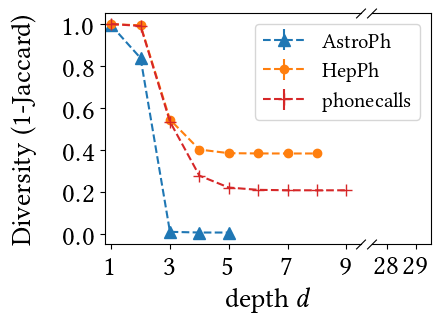

In [111]:
# 2022_02_11__11_08_39
load_date = "2024_02_09__18_12_13"#datetime(2022,2,11, 11,8,39)

xlims = ((0.8, 9.5), (27.5, 29.5))
yticks = [i/10 for i in range(0,11,2)]
ylims = [(-0.05, 1.05)]
xticks = [range(1,10,2), [28,29]]

quickplot(load_date, "jaccard" , save_date=load_date, xlims=xlims, ylims = ylims, yticks=yticks, xticks=xticks, legend="normal")

In [92]:
xlim = (-0.3+1,25.3)

(0.05, 0.05)


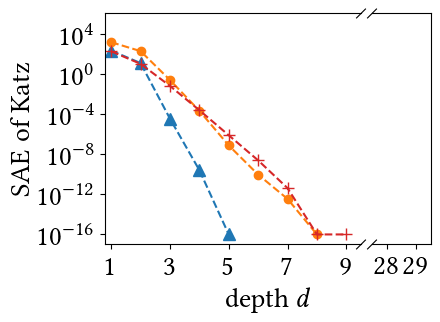

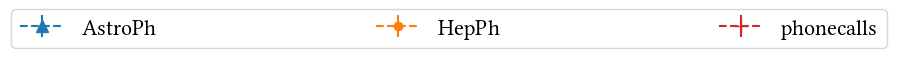

In [110]:
load_date = "2024_02_09__16_31_19"#datetime(2022,1,6, 0,18,32)

xlims = ((0.8, 9.5), (27.5, 29.5))
yticks = [10**i for i in range(-16,5,4)]
ylims = [(1e-17, 1e6)]
xticks = [range(1,10,2), [28,29]]
quickplot(load_date, "katz" , save_date=load_date, xlims=xlims, ylims = ylims, yticks=yticks, xticks=xticks, legend="outer")

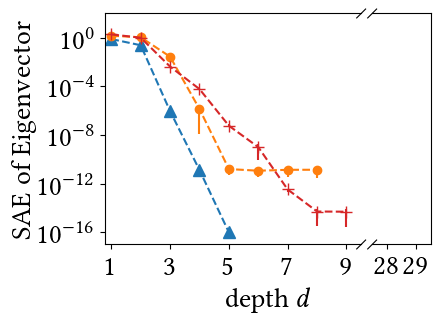

In [107]:
load_date = "2024_02_09__15_51_33"#datetime(2022,1,7, 19,11,2)
xlims = [(0.8, 9.5), (27.5, 29.5)]
yticks = [10**i for i in range(-16,5,4)]
ylims = [(1e-17, 1e2)]
xticks = [range(1,10,2), [28,29]]
quickplot(load_date, "eigenvector" , save_date=load_date, xlims=xlims, ylims = ylims, yticks=yticks,xticks=xticks, )

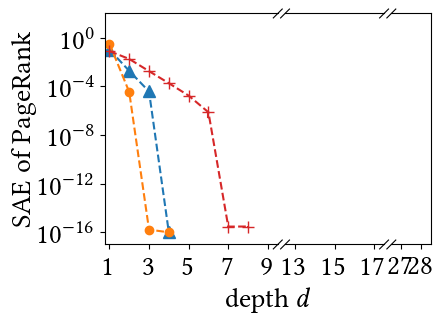

In [108]:

load_date = "2024_02_09__15_38_39"
xlims = [(0.8, 9.5), (12.5, 17.5), (26.5, 28.5)]
yticks = [10**i for i in range(-16,5,4)]
ylims = [(1e-17, 1e2)]
xticks = [range(1,10,2), [13,15,17], [27,28]]
quickplot(load_date, "pagerank" , save_date=load_date, xlims=xlims, ylims = ylims, xticks=xticks,yticks=yticks,)

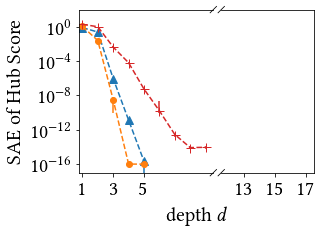

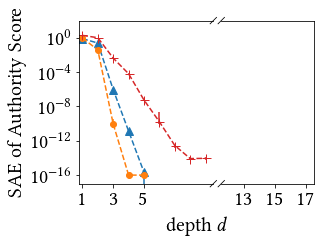

In [70]:

load_date = "2023_01_31__17_39_24"#datetime(2022,2,3, 23,58,26)
xlims = [(0.8, 9.5), (11.5, 17.5)]
yticks = [10**i for i in range(-16,5,4)]
ylims = [(1e-17, 1e2)]
xticks = [range(1,6,2), range(13,18,2)]
quickplot(load_date, "hits" , save_date=load_date, xlims=xlims, ylims = ylims, xticks=xticks,yticks=yticks,)